In [1]:
import sys
from pathlib import Path

import torch
from torchvision import transforms
from torchvision.datasets import MNIST, EMNIST
from tqdm import trange

In [2]:
# Update path to import src code
sys.path.append("..")

In [3]:
from src import SplitNN, ConvAttackModel, plot_images

In [4]:
project_root = Path.cwd().resolve().parent

In [5]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

---
# 5. NoPeek
In this experiment
we investigate combining NoPeekNN with noise

## Load target model
Load a model trained without noise

In [6]:
model_path = project_root / "models" / "splitnn_01nopeek_10noise.pth"
noiseless_model_path = project_root / "models" / "splitnn_01nopeek.pth"

In [7]:
noise = 3.0
target_model = SplitNN(noise)

checkpoint = torch.load(model_path)
target_model.load_state_dict(checkpoint["model_state_dict"])

target_model = target_model.to(device)
target_model.eval()
target_model

SplitNN(
  (part1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=9216, out_features=500, bias=True)
    (7): ReLU()
  )
  (part2): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

## Evaluate model

In [8]:
data_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
)

In [9]:
mnist_train = MNIST(project_root / "data", download=True, train=True, transform=data_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=256)

## Confirm target model performance

In [10]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[:5_000]
mnist_test.targets = mnist_test.targets[:5_000]

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000)

In [11]:
target_test_correct = 0
target_test_total = 0

target_model.eval()
for data, targets in mnist_test_loader:
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        outputs, _ = target_model(data)

    target_test_correct += outputs.max(1)[1].eq(targets).sum().item()
    target_test_total += outputs.size(0)

target_test_accuracy = 100 * target_test_correct / target_test_total
print(f"Target model accuracy: {target_test_accuracy:.3f}")

Target model accuracy: 88.780


## Compare to noiseless model
How does adding this noise compare to noiseless model?

In [12]:
noiseless_model = SplitNN(0.0)

checkpoint = torch.load(noiseless_model_path)
noiseless_model.load_state_dict(checkpoint["model_state_dict"])

noiseless_model = noiseless_model.to(device)
noiseless_model.eval()

SplitNN(
  (part1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=9216, out_features=500, bias=True)
    (7): ReLU()
  )
  (part2): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

In [13]:
noiseless_test_correct = 0
noiseless_test_total = 0

for data, targets in mnist_test_loader:
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        outputs, _ = noiseless_model(data)

    noiseless_test_correct += outputs.max(1)[1].eq(targets).sum().item()
    noiseless_test_total += outputs.size(0)

noiseless_test_accuracy = 100 * noiseless_test_correct / noiseless_test_total
print(f"Noiseless model accuracy: {noiseless_test_accuracy:.3f}")

Noiseless model accuracy: 92.880


## Train attacker
We will train the attack model on EMNIST images.
These are similar enough to MNIST for the attack to work in principle,
but different enough to simulate a real-world attack setting (unknown training data).

In [20]:
emnist_train = EMNIST(project_root / "data", "letters", download=True, train=True, transform=data_transform)
emnist_train.data = emnist_train.data[: 1_000]
emnist_train.targets = emnist_train.targets[: 1_000]

emnist_loader = torch.utils.data.DataLoader(emnist_train, batch_size=128)

In [21]:
attack_model = ConvAttackModel().to(device)
attack_model.train()
attack_optim = torch.optim.Adam(attack_model.parameters(), lr=1e-4)

for epoch in trange(5):
    for data, _ in emnist_loader:
        attack_optim.zero_grad()

        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            _, intermediate_data = target_model(data)

        reconstructed_data = attack_model(intermediate_data)

        loss = ((reconstructed_data - data)**2).mean()
        loss.backward()
        attack_optim.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.44s/it]


## Train attacker on noiseless model

In [22]:
noiseless_attack_model = ConvAttackModel().to(device)
noiseless_attack_model.train()
noiseless_attack_optim = torch.optim.Adam(noiseless_attack_model.parameters(), lr=1e-4)

for epoch in trange(5):
    for data, _ in emnist_loader:
        noiseless_attack_optim.zero_grad()

        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            _, intermediate_data = noiseless_model(data)
            

        reconstructed_data = noiseless_attack_model(intermediate_data)

        loss = ((reconstructed_data - data)**2).mean()
        loss.backward()
        noiseless_attack_optim.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.56s/it]


## Visualise reconstruction

In [23]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[5_000:]
mnist_test.targets = mnist_test.targets[5_000:]

### Noisy model

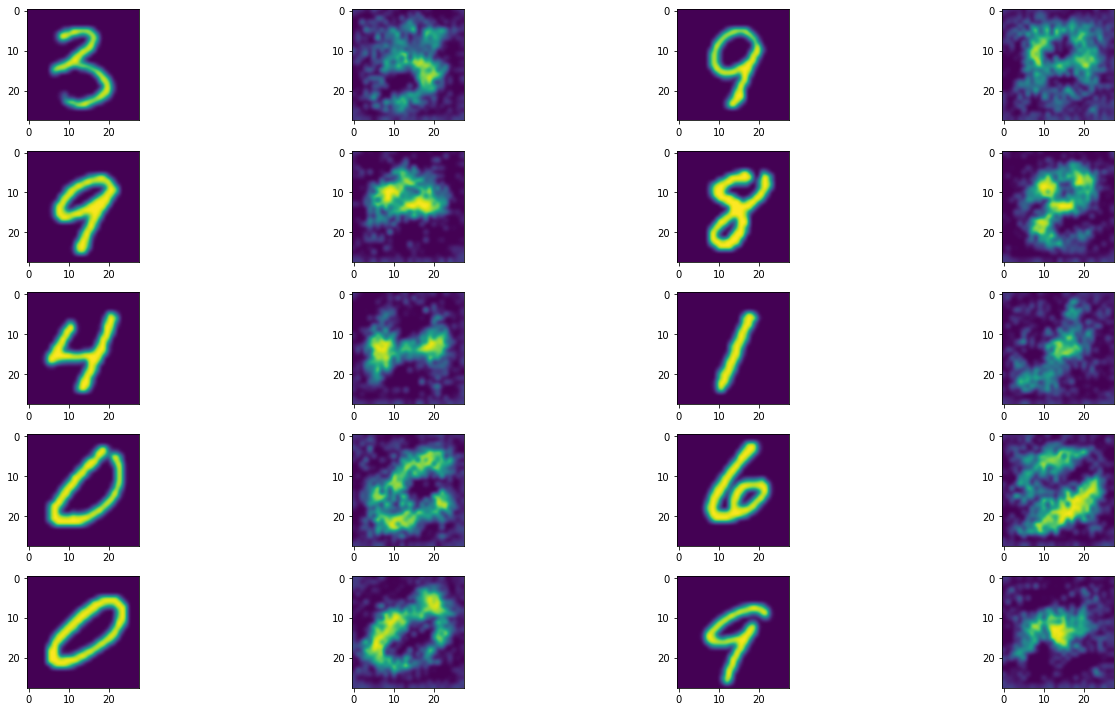

In [24]:
ims = []

for i in range(10):
    image, _ = mnist_test[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims)

### Compare noisy and noiseless models

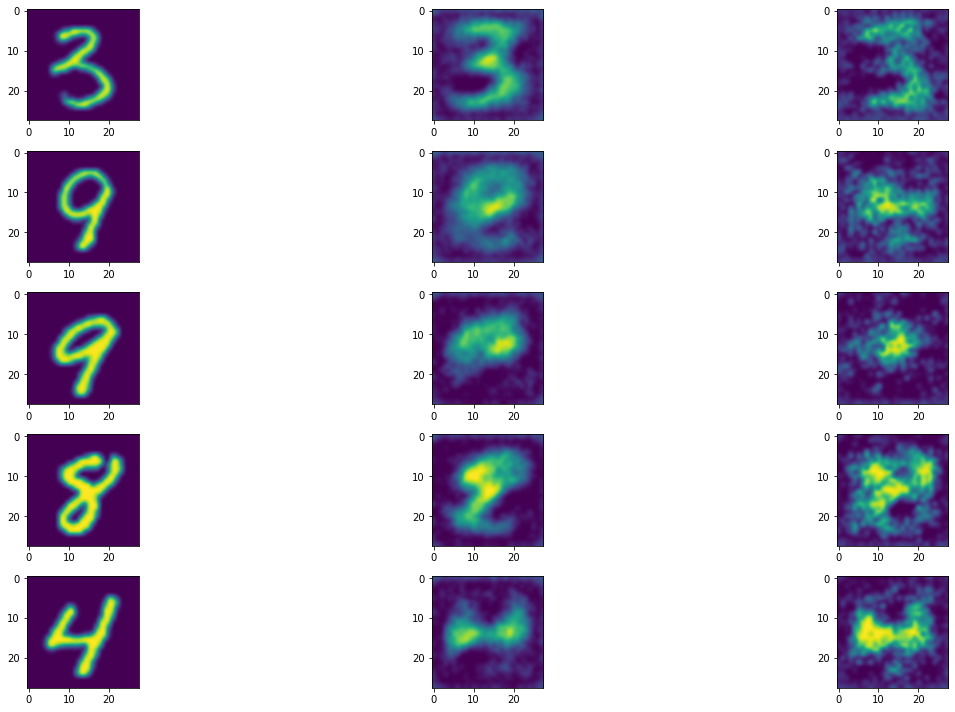

In [27]:
ims = []

for i in range(5):
    image, _ = mnist_test[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model(intermediate)

        intermediate_noiseless = noiseless_model.encode(image.unsqueeze(0))
        reconstructed_noiseless = noiseless_attack_model(intermediate_noiseless) 

    reconstructed = reconstructed.squeeze(0)
    reconstructed_noiseless = reconstructed_noiseless.squeeze(0)
    ims.extend([image, reconstructed_noiseless, reconstructed])

plot_images(ims, rows=5, cols=3)